In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from PIL import Image 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sklearn as sk
from sklearn.model_selection import train_test_split
import pickle

print(tf.__version__)

2024-12-10 19:46:34.617318: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-10 19:46:34.623943: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 19:46:34.631762: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 19:46:34.634293: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 19:46:34.640159: I tensorflow/core/platform/cpu_feature_guar

2.17.0


In [2]:
gpus = tf.config.list_physical_devices('GPU')
gpuid = 0 #int(args.gpu_id)                                                                                                                           
if gpus:
  # Restrict TensorFlow to only allocate X GB of memory on the first GPU                                                                              
  try:
    tf.config.set_visible_devices(gpus[gpuid], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[gpuid], True)
    '''
    tf.config.set_logical_device_configuration(
        gpus[gpuid],
        [tf.config.LogicalDeviceConfiguration(memory_limit=12000)])
    '''
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized                                                                                   
    print(e)

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1733885197.594761   60267 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733885197.618823   60267 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733885197.621208   60267 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733885197.624760   60267 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [3]:
#with tf.device('/job:localhost/replica:0/task:0/device:GPU:0'):
inputs = np.load("all_inputs.npy")

In [4]:

targets = np.load("all_targets.npy")
# train test split
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.2)

In [5]:
inputs.shape

(1704, 1024, 1024, 1)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [7]:
# added more layers because original model didn't have enough downsampling
# old model had 266M params
conv_dim = 8
ff_dim = 32
k_dim = 5
pool_dim = 2
drop_rate = 0.1

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(conv_dim, kernel_size = (k_dim, k_dim), activation='relu', input_shape=(1024, 1024, 1)),
  tf.keras.layers.Conv2D(conv_dim, kernel_size = (k_dim, k_dim), activation='relu'),
  tf.keras.layers.MaxPooling2D((pool_dim, pool_dim)),
  tf.keras.layers.Dropout(drop_rate),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(ff_dim, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.summary()

/home/user/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 1020, 1020, 8)  │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 1016, 1016, 8)  │         1,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 508, 508, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 508, 508, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2064512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │    66,064,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,066,265 (252.02 MB)

 Trainable params: 66,066,265 (252.02 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
conv_dim = 16
ff_dim = 32
k_dim = 21
pool_dim = 3
drop_rate = 0.2

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(conv_dim, kernel_size = (k_dim, k_dim), activation='relu', input_shape=(1024, 1024, 1)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.AveragePooling2D(pool_dim,pool_dim),
  tf.keras.layers.Dropout(drop_rate),
  tf.keras.layers.Conv2D(conv_dim, kernel_size = (k_dim, k_dim), padding ='valid'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.AveragePooling2D(pool_dim,pool_dim),
  tf.keras.layers.Dropout(drop_rate),
  tf.keras.layers.Conv2D(conv_dim, kernel_size = (k_dim, k_dim), padding ='valid'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.AveragePooling2D(pool_dim,pool_dim),
  tf.keras.layers.Dropout(drop_rate),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(ff_dim, activation='relu'),
  tf.keras.layers.Dropout(drop_rate),
  tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.summary()

/home/user/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 1004, 1004, 16) │         7,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1004, 1004, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 1004, 1004, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 334, 334, 16)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 334, 334, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 314, 314, 16)   │       112,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 314, 314, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 314, 314, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 104, 104, 16)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 104, 104, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 84, 84, 16)     │       112,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 84, 84, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 84, 84, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 28, 28, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       401,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 634,561 (2.42 MB)

 Trainable params: 634,465 (2.42 MB)

 Non-trainable params: 96 (384.00 B)

In [7]:
#model.compile(optimizer=Adam(learning_rate=1e-4),
#model.compile(optimizer=Adam(learning_rate=1e-2),
#model.compile(optimizer=Adam(learning_rate=1e-5),
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='binary_crossentropy',  
              metrics=['accuracy'])

In [9]:
batchsize = 8
# buffer size is # of elements, not MB
train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train))
train_dataset = train_dataset.shuffle(buffer_size=batchsize*2).batch(batchsize)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test))
test_dataset = test_dataset.shuffle(buffer_size=batchsize*2).batch(batchsize)

In [8]:
model_checkpoint = ModelCheckpoint(
  filepath='checkpoint.model129.keras',
  monitor='val_loss',
  mode='min',
  save_best_only=True)

optim = model.fit(X_train,y_train, 
                  epochs=100, 
                  validation_split =.2,
                  callbacks=[model_checkpoint])

Epoch 1/100


I0000 00:00:1733885234.090332   60409 service.cc:146] XLA service 0x7a2ba0012c90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733885234.090354   60409 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2024-12-10 19:47:14.216872: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-10 19:47:14.359304: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-12-10 19:47:19.515337: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[32,16,314,314]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,16,334,334]{3,2,1,0}, f32[16,16,21,21]{3,2,1,0}, f32[16]{0}), window={size=21x21}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_i

 1/35 ━━━━━━━━━━━━━━━━━━━━ 29:13 52s/step - accuracy: 0.5938 - loss: 0.7605

I0000 00:00:1733885284.558051   60409 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.6649 - loss: 0.8702

E0000 00:00:1733885292.598716   60409 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1733885292.677972   60409 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6662 - loss: 0.8634

E0000 00:00:1733885297.404410   60411 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1733885297.528129   60411 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1733885300.419939   60409 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1733885300.542063   60409 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


35/35 ━━━━━━━━━━━━━━━━━━━━ 71s 558ms/step - accuracy: 0.6674 - loss: 0.8569 - val_accuracy: 0.5055 - val_loss: 21.9100
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.7936 - loss: 0.4088 - val_accuracy: 0.6081 - val_loss: 0.8229
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.8337 - loss: 0.3869 - val_accuracy: 0.6117 - val_loss: 0.8555
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.8593 - loss: 0.3137 - val_accuracy: 0.5385 - val_loss: 0.6340
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.8344 - loss: 0.3655 - val_accuracy: 0.5055 - val_loss: 0.6489
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.8625 - loss: 0.3734 - val_accuracy: 0.5201 - val_loss: 1.1974
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.8944 - loss: 0.2418 - val_accuracy: 0.4945 - val_loss: 2.8446
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.8915 - loss: 0.2351 - val_accuracy: 0.50

In [10]:
optim.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

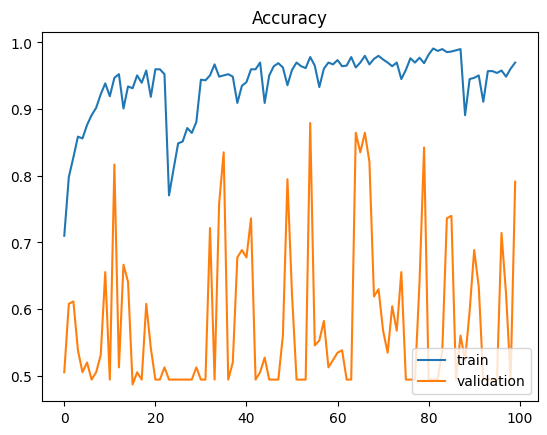

In [9]:
plt.plot(optim.history['accuracy'])
plt.plot(optim.history['val_accuracy'])
plt.legend(['train', 'validation'], loc='lower right')
plt.title('Accuracy')
plt.show()

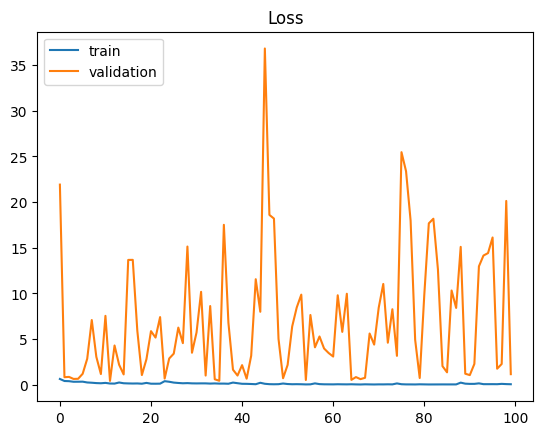

In [10]:
plt.plot(optim.history['loss'])
plt.plot(optim.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper left')
plt.title('Loss')
plt.show()

In [11]:
np.array(optim.history['val_accuracy']).max()

0.8791208863258362

In [2]:
from tensorflow.keras.models import load_model

best_model = load_model('checkpoint.model.keras')

I0000 00:00:1727150037.179535   10424 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727150037.263451   10424 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727150037.265360   10424 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727150037.268261   10424 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [6]:
test_loss, test_acc = best_model.evaluate(X_test, y_test)

I0000 00:00:1727150086.442717   10653 service.cc:146] XLA service 0x7d0fb8008b40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727150086.442745   10653 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2024-09-23 21:54:46.454102: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-23 21:54:46.503821: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
E0000 00:00:1727150087.277009   10653 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1727150087.396536   10653 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Sys

 3/11 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9635 - loss: 0.1290

I0000 00:00:1727150092.752241   10653 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9568 - loss: 0.1596

E0000 00:00:1727150094.071145   10649 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1727150094.189865   10649 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 499ms/step - accuracy: 0.9572 - loss: 0.1680


In [7]:
'Test loss:{0}, Test accuracy: {1}'.format(test_loss,test_acc)

'Test loss:0.21031822264194489, Test accuracy: 0.9589442610740662'

In [8]:
# Predict the values from the testing dataset
Y_pred_probs = best_model.predict(X_test)
Y_pred = np.array(Y_pred_probs>=.5)
# compute the confusion matrix
#confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred) 

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


In [1]:
plt.hist(Y_pred_probs.flatten())
plt.title('Probability distribution of Predictions')
plt.xlabel('Probability')
plt.ylabel('freq')

NameError: name 'plt' is not defined

Text(0, 0.5, 'freq')

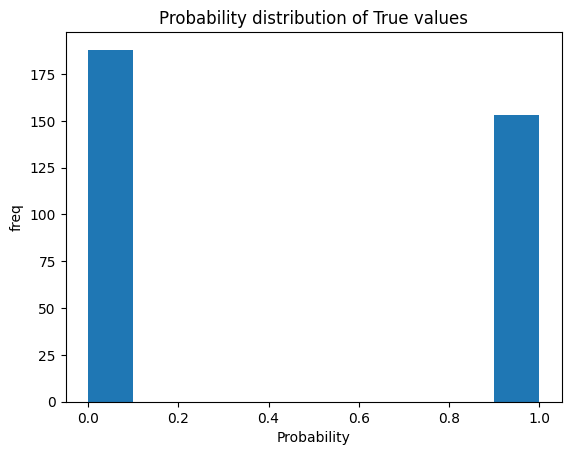

In [10]:
plt.hist(y_test)
plt.title('Probability distribution of True values')
plt.xlabel('Probability')
plt.ylabel('freq')

In [1]:
sum(y_test)

NameError: name 'y_test' is not defined

In [12]:
Y_pred = Y_pred.astype(float).flatten()

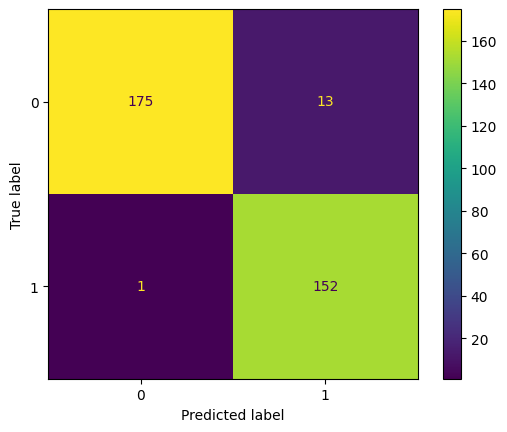

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, Y_pred) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


In [17]:
TP=152
TN=175
FP=13
FN=1

In [18]:
recall = TP/(TP+FN)
precision = TP/(TP+FP)

print(recall,precision)

0.9934640522875817 0.9212121212121213


In [19]:
(TP+TN)/(TP+TN+FP+FN)

0.9589442815249267